# Kaggle設置

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read env var
!pip install python-dotenv
import dotenv
import os

dotenv.load_dotenv("/content/drive/MyDrive/中興_人工智慧概論/HW_final/.env")
api_token = {"username":os.getenv("KAGGLE_USERNAME"),"key":os.getenv("KAGGLE_KEY")}

!pip install kaggle

import json

kaggle_path = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_path, exist_ok=True)

with open(os.path.join(kaggle_path, "kaggle.json"), "w") as f:
    json.dump(api_token, f)

os.chmod(os.path.join(kaggle_path, "kaggle.json"), 0o600)

In [ ]:
api_token["username"]

'johnnydo0730'

# 定義訓練流程之通用函數

## 載入套件

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# use the model you want
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

## 定義Dataloader

In [ ]:
def get_dataloader(train_dir, preprocess_input=None, img_size=(224, 224), batch_size=32):

  # 定義dataloader，使用資料增強（Data Augmentation）
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,  # 隨機錯切
      zoom_range=0.2,   # 隨機縮放
      horizontal_flip=True,  # 水平翻轉
      rotation_range=20,  # 隨機旋轉
      fill_mode='nearest',  # 填補模式
      validation_split=0.2
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical', # categorical
      subset='training'
  )

  val_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, val_generator


## 重製分類頭並建立模型

| 模型             | 特徵圖輸出形狀 (before GAP) | GAP後形狀 (Dense輸入) |
| -------------- | -------------------- | ---------------- |
| VGG19          | (7, 7, 512)          | (512,)           |
| ResNet50       | (7, 7, 2048)         | (2048,)          |
| EfficientNetB0 | (7, 7, 1280)         | (1280,)          |


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers

def replace_classification_head(old_model, num_classes):
    """
    從已訓練模型載入，去除分類頭，並重新建立相同架構的新分類頭。

    傳入：
        old_model: 儲存為 .keras 的舊模型（含分類頭）
        num_classes: 新任務的分類數

    回傳：
        model: 去除舊分類頭並加上新分類頭的模型
    """
    activation = 'softmax' if num_classes > 1 else 'sigmoid'

    # 根據 summary 找到去除分類頭的最後一層（通常是倒數第3或第4層）
    # 假設原本分類頭前是 GlobalAveragePooling2D，我們保留這層的輸出
    # 若你原本是直接接 Dense，請修改下方 get_layer 名稱
    feature_layer = old_model.get_layer("global_average_pooling2d")

    x = feature_layer.output
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output_tensor = layers.Dense(num_classes, activation=activation)(x)

    # 建立新模型
    new_model = Model(inputs=old_model.input, outputs=output_tensor)
    return new_model


## callback tools

In [ ]:
import pickle
import os

class HistorySaver(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
'''
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
'''

"\nlr_scheduler = ReduceLROnPlateau(\n    monitor='val_loss',\n    factor=0.5,\n    patience=2,\n    min_lr=1e-7,\n    verbose=1\n)\n"

## 定義訓練函數

In [ ]:
def train_model_with_gpu_check(model, train_generator, val_generator, lr, epochs, save_dir, phase, lr_scheduler=None):
    """
    檢查 GPU 可用性並訓練模型，儲存最佳模型。

    參數：
        model: 已經編譯好的模型。
        train_generator: 訓練數據生成器（如 ImageDataGenerator 生成器）。
        val_generator: 驗證數據生成器（如 ImageDataGenerator 生成器）。
        epochs: 訓練的輪數（預設為 5）。
        save_dir: 儲存模型的資料夾（預設為 'models'）。
        phase: 訓練階段（'phase1' 或 'phase2'）

    回傳：
        history: 訓練過程的歷史紀錄。
    """

    # 檢查是否有可用的 GPU
    gpus = tf.config.list_physical_devices('GPU')
    #if len(gpus) == 0:
        #raise Exception("No GPU available, stop traing process")
    print("Num GPUs Available: ", len(gpus))

    #loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

    # 設定儲存中間資訊
    checkpoint = ModelCheckpoint(os.path.join(save_dir, phase + '_best_model.keras'), monitor='val_loss', save_best_only=True)
    history_saver = HistorySaver(os.path.join(save_dir, phase + '_history.pkl'))

    # 預設 learning rate scheduler
    callbacks = [checkpoint, history_saver]
    if lr_scheduler is not None:
        callbacks.append(lr_scheduler)

    # 訓練模型
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

## 視覺化呈現

In [ ]:
def plot_learning_curve_with_split(history, save_dir, phase):
    """
    根據 keras 的 history 物件繪製並儲存學習曲線。
    儲存三張圖：合併版、acc 單獨圖、loss 單獨圖。

    參數：
        history: keras.callbacks.History（model.fit() 的回傳結果）
        save_dir: 儲存圖像的資料夾（預設為 'output'）
    """
    os.makedirs(save_dir, exist_ok=True)

    # 1. 合併版
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, phase + '_learning_curve.png'))
    plt.show()

    # 2. Accuracy 單獨
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))
    plt.savefig(os.path.join(save_dir, phase + '_accuracy_curve.png'))
    #plt.show()

    # 3. Loss 單獨
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))
    plt.savefig(os.path.join(save_dir, phase + '_loss_curve.png'))
    #plt.show()


## 保存模型

In [ ]:
import os

def save_model(model, save_dir, filename):
    """
    儲存 Keras 模型為指定格式（支援 .keras 或 .h5）

    參數：
        model: 已訓練的 Keras 模型
        filename: 儲存檔名（預設為 'model.keras'）
        save_dir: 儲存資料夾（預設為 'models'）
    """
    os.makedirs(save_dir, exist_ok=True)
    full_path = os.path.join(save_dir, filename)
    model.save(full_path)
    print(f"✅ 模型已儲存至 {full_path}")


# 定義測試流程之通用函數

## 載入套件

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import cv2
import os

## acc, loss

In [ ]:
def evaluate_model(model, test_generator):
    loss, acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Loss: {loss:.4f}")
    return acc, loss

## confusion matrix

In [ ]:
def plot_confusion_matrix(model, test_generator, class_names, save_dir):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.show()

    print(classification_report(y_true, y_pred_classes, target_names=class_names))


## misclassifications sample

In [ ]:

def analyze_misclassifications(model, test_generator, class_names, num_samples=5):
    # 取得真實標籤與預測結果
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # 找出預測錯誤的索引
    wrong_idxs = np.where(y_pred_classes != y_true)[0]
    print(f"Found {len(wrong_idxs)} misclassified samples.")

    # 顯示前 num_samples 筆錯誤樣本
    for idx in wrong_idxs[:num_samples]:
        img_path = test_generator.filepaths[idx]
        true_class = class_names[y_true[idx]]
        pred_class = class_names[y_pred_classes[idx]]

        # 載入原始圖片（注意 test_generator 是 flow_from_directory 的）
        img = cv2.imread(img_path)  # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉為 RGB 給 matplotlib 用

        plt.imshow(img)
        plt.title(f"True: {true_class}, Pred: {pred_class}")
        plt.axis('off')
        plt.show()


## grad cam

In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.3 MB/s eta 0:00:00


In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def deprocess_image(img_tensor):
    """
    將 preprocess_input() 處理過的影像還原回 [0, 1] RGB 範圍，用於顯示。
    """
    img = img_tensor.copy()
    # 針對 ResNet / VGG 系列的預處理進行還原
    img += [103.939, 116.779, 123.68]  # BGR -> RGB
    img = img[..., ::-1]  # BGR to RGB
    img = np.clip(img / 255.0, 0, 1)  # normalize
    return img

def visualize_gradcam_with_vis(model, test_generator, class_names, layer_name='conv5_block3_out', num_samples=3):
    test_generator.reset()

    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    for i in range(num_samples):
        img_batch, label = test_generator[i]
        img = img_batch[0:1]
        true_class_index = np.argmax(label[0])
        pred = model.predict(img)
        pred_class = np.argmax(pred[0])

        score = CategoricalScore([pred_class])
        cam = gradcam(score, img, penultimate_layer=layer_name)
        heatmap = cam[0]

        # 還原預處理圖像以正確顯示
        restored_img = deprocess_image(img[0])

        plt.figure()
        plt.imshow(restored_img)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        title = f"Grad-CAM: Actual={class_names[true_class_index]} ,Pred={class_names[pred_class]}" if class_names else f"Class {pred_class}"
        plt.title(title)
        plt.axis('off')
        plt.show()


In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def deprocess_image(img_tensor):
    """
    將 preprocess_input() 處理過的影像還原回 [0, 1] RGB 範圍，用於顯示。
    """
    img = img_tensor.copy()
    img += [103.939, 116.779, 123.68]  # BGR mean
    img = img[..., ::-1]  # BGR to RGB
    img = np.clip(img / 255.0, 0, 1)
    return img

def visualize_gradcam_each_class(model, test_generator, class_names, layer_name='conv5_block3_out'):
    test_generator.reset()
    gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

    collected_classes = set()
    total_classes = len(test_generator.class_indices)

    for batch_img, batch_label in test_generator:
        for i in range(len(batch_img)):
            img = batch_img[i:i+1]
            true_class = np.argmax(batch_label[i])
            if true_class in collected_classes:
                continue

            # 預測與 Grad-CAM
            pred = model.predict(img)
            pred_class = np.argmax(pred[0])
            score = CategoricalScore([pred_class])
            cam = gradcam(score, img, penultimate_layer=layer_name)
            heatmap = cam[0]

            # 顯示圖像
            restored_img = deprocess_image(img[0])
            plt.figure()
            plt.imshow(restored_img)
            plt.imshow(heatmap, cmap='jet', alpha=0.5)
            title = f"Class {true_class} → Pred: {pred_class}" if not class_names else f"{class_names[true_class]} → {class_names[pred_class]}"
            plt.title(title)
            plt.axis('off')
            plt.show()

            collected_classes.add(true_class)
            if len(collected_classes) == total_classes:
                return


# 遷移到學習情緒

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download joyee19/studentengagement
!unzip -q studentengagement.zip

Dataset URL: https://www.kaggle.com/datasets/joyee19/studentengagement
License(s): unknown
  0% 0.00/38.3M [00:00<?, ?B/s]
100% 38.3M/38.3M [00:00<00:00, 879MB/s]


In [ ]:
import os
import shutil
import random

def flatten_and_split_emotion_dataset(original_root, converted_root, train_ratio=0.9, seed=42):
    """
    將原始情緒資料集展平為六類，並分割為 train/test。

    參數：
        original_root: 原始資料集根目錄，例如 "emotion_dataset_raw/"
        converted_root: 輸出目錄，例如 "emotion_dataset_flat/"
        train_ratio: 訓練資料比例（預設 0.9）
        seed: 隨機種子（確保可重現）
    """
    random.seed(seed)

    train_root = os.path.join(converted_root, "train")
    test_root = os.path.join(converted_root, "test")
    os.makedirs(train_root, exist_ok=True)
    os.makedirs(test_root, exist_ok=True)

    # 第一層是大分類（例如 Engaged, Not Engaged）
    for parent_class in os.listdir(original_root):
        parent_path = os.path.join(original_root, parent_class)
        if not os.path.isdir(parent_path):
            continue

        # 第二層是實際子類別（例如 confused, bored 等）
        for subclass in os.listdir(parent_path):
            subclass_path = os.path.join(parent_path, subclass)
            if not os.path.isdir(subclass_path):
                continue

            images = [f for f in os.listdir(subclass_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)

            split_idx = int(len(images) * train_ratio)
            train_images = images[:split_idx]
            test_images = images[split_idx:]

            for phase, image_list in [("train", train_images), ("test", test_images)]:
                target_dir = os.path.join(converted_root, phase, subclass)
                os.makedirs(target_dir, exist_ok=True)

                for filename in image_list:
                    src = os.path.join(subclass_path, filename)
                    dst = os.path.join(target_dir, filename)

                    # 若重名可加前綴避免覆蓋
                    if os.path.exists(dst):
                        base, ext = os.path.splitext(filename)
                        dst = os.path.join(target_dir, f"{parent_class}_{base}{ext}")

                    shutil.copy2(src, dst)

            print(f"[{subclass}] 訓練: {len(train_images)} 張，測試: {len(test_images)} 張")

    print("轉換與分割完成：已建立 train/test 資料夾。")

flatten_and_split_emotion_dataset(
    original_root="/content/Student-engagement-dataset",
    converted_root="/content/emotion_dataset_flat",
    train_ratio=0.9
)


[confused] 訓練: 332 張，測試: 37 張
[frustrated] 訓練: 324 張，測試: 36 張
[engaged] 訓練: 312 張，測試: 35 張
[Looking Away] 訓練: 380 張，測試: 43 張
[bored] 訓練: 322 張，測試: 36 張
[drowsy] 訓練: 236 張，測試: 27 張
轉換與分割完成：已建立 train/test 資料夾。


## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

'''
# 把灰階轉成 RGB 並使用 keras 的 preprocess_input
def custom_preprocessing(img):
    # 將 numpy 陣列轉為 Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # 若是灰階（只有1個通道），轉成 RGB
    if img_tensor.shape[-1] == 1:
        img_tensor = tf.image.grayscale_to_rgb(img_tensor)

    # 再轉回 numpy 並套用 Keras 的預處理（如：ResNet50 的預處理）
    img_rgb = img_tensor.numpy()
    img_rgb = preprocess_input(img_rgb)

    return img_rgb
'''

def get_engagement_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_engagement_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
# 載入在FER+訓練的EfficientNetB0模型
num_classes = 6
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/engagement_emotion"

Found 1527 images belonging to 6 classes.
Found 379 images belonging to 6 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.2436 - loss: 1.7369 - val_accuracy: 0.6148 - val_loss: 1.3041
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 698ms/step - accuracy: 0.6054 - loss: 1.1746 - val_accuracy: 0.6913 - val_loss: 1.0243
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 819ms/step - accuracy: 0.7021 - loss: 0.9021 - val_accuracy: 0.6966 - val_loss: 0.8898
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 632ms/step - accuracy: 0.7244 - loss: 0.7772 - val_accuracy: 0.7388 - val_loss: 0.7913
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 729ms/step - accuracy: 0.7874 - loss: 0.6587 - val_accuracy: 0.7599 - val_loss: 0.7154


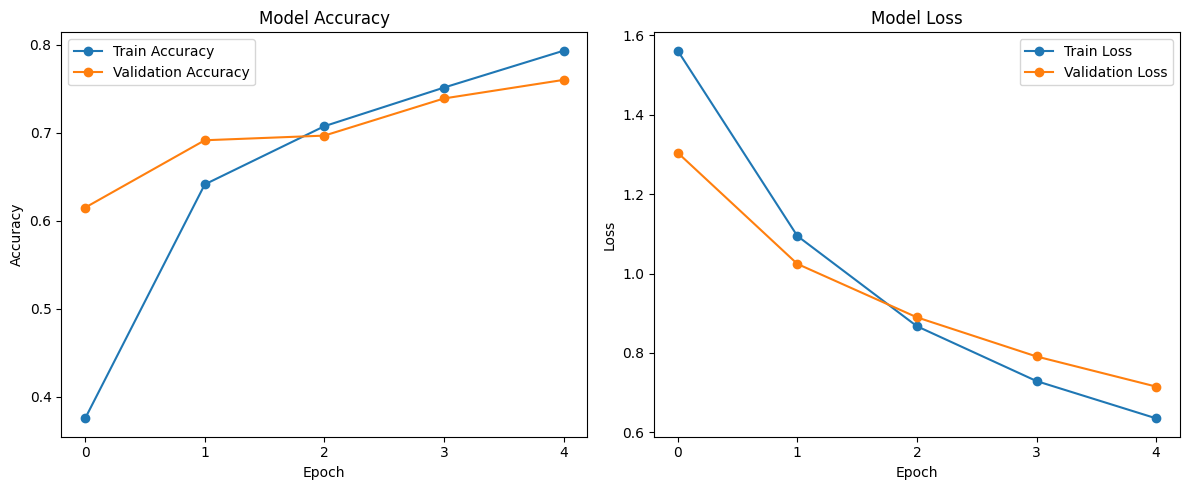

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/engagement_emotion/EfficientNetB0_engagement_phase1.keras


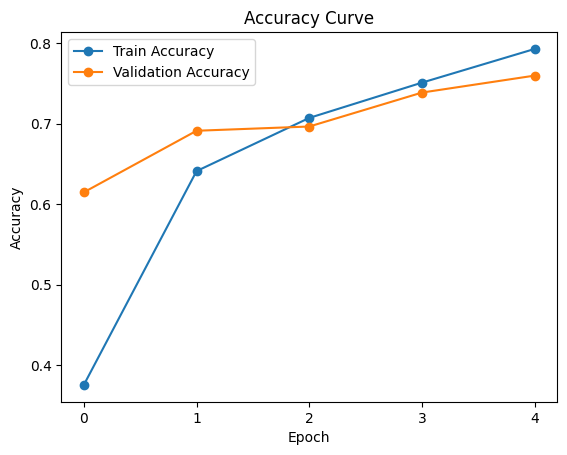

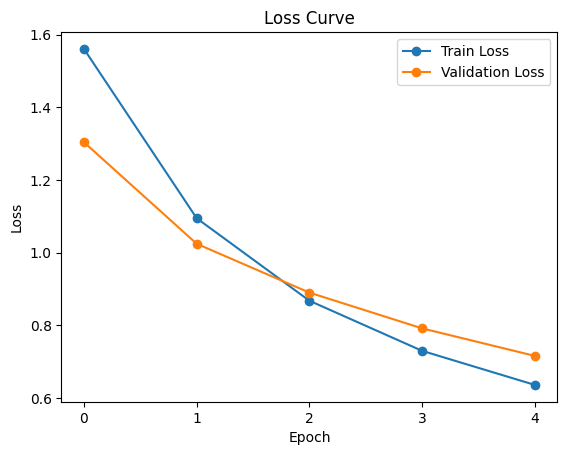

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

model = models.load_model("/content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FERplus/EfficientNetB0_FERplus_phase3.keras", compile=False)

model.trainable = True  # 凍結卷積層
model = replace_classification_head(model, num_classes)
for layer in model.layers[:237]: # 237 | top_activation
    layer.trainable = False
for layer in model.layers[237:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_engagement_trainloader("/content/emotion_dataset_flat/train", batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_engagement_" + phase + ".keras")

Found 1527 images belonging to 6 classes.
Found 379 images belonging to 6 classes.
Num GPUs Available:  1
Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8333 - loss: 0.5557 - val_accuracy: 0.7309 - val_loss: 0.6715
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 639ms/step - accuracy: 0.8325 - loss: 0.4957 - val_accuracy: 0.7836 - val_loss: 0.6408
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 654ms/step - accuracy: 0.8371 - loss: 0.4610 - val_accuracy: 0.7731 - val_loss: 0.6081
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 631ms/step - accuracy: 0.8610 - loss: 0.4081 - val_accuracy: 0.7836 - val_loss: 0.6022
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 667ms/step - accuracy: 0.8554 - loss: 0.3922 - val_accuracy: 0.7916 - val_loss: 0.5831


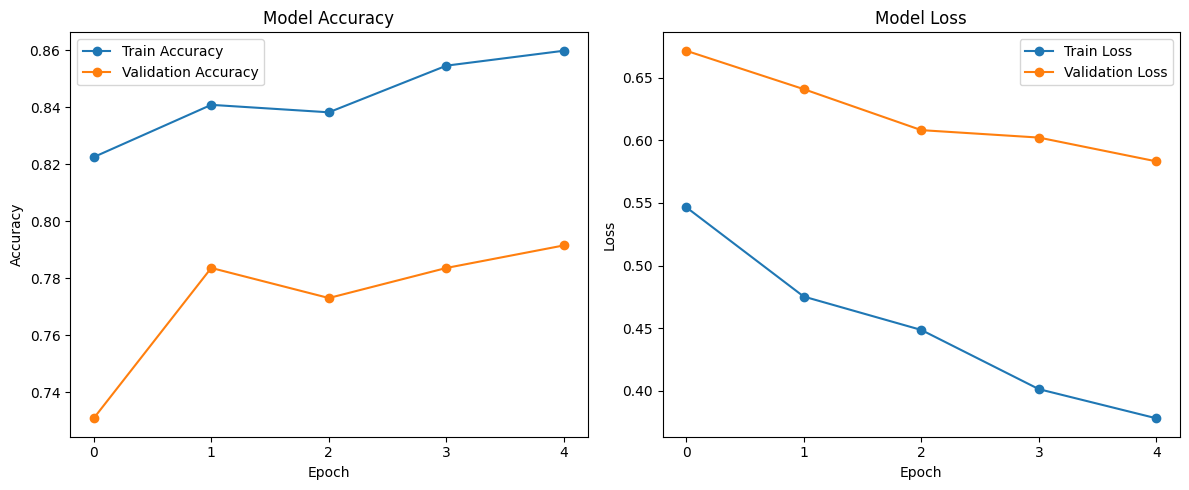

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/engagement_emotion/EfficientNetB0_engagement_phase2.keras


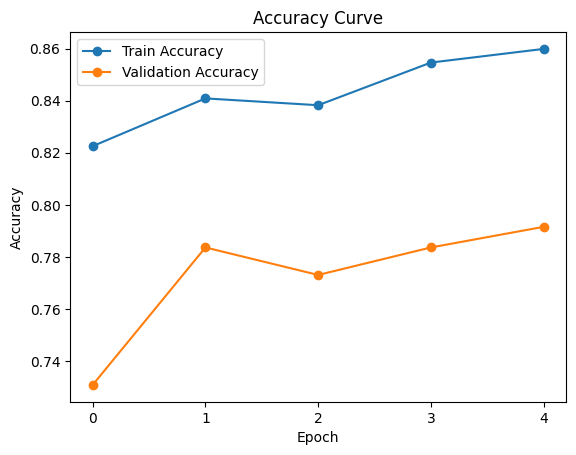

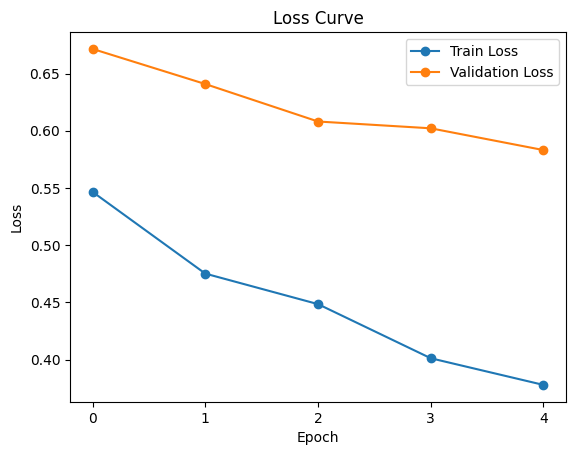

In [ ]:
# Phase 2:
lr = 1e-5
epochs = 5
batch_size = 32
phase = 'phase2'

model = models.load_model(os.path.join(save_dir, "EfficientNetB0_engagement_phase1.keras"), compile=False)

model.trainable = True  # 凍結卷積層
for layer in model.layers[:222]: # 222 | block7a_expand_conv
    layer.trainable = False
for layer in model.layers[222:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_engagement_trainloader("/content/emotion_dataset_flat/train", batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_engagement_" + phase + ".keras")

## 測試

Found 214 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 698ms/step - accuracy: 0.4919 - loss: 1.1500
Test Accuracy: 0.4953
Test Loss: 1.1848
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


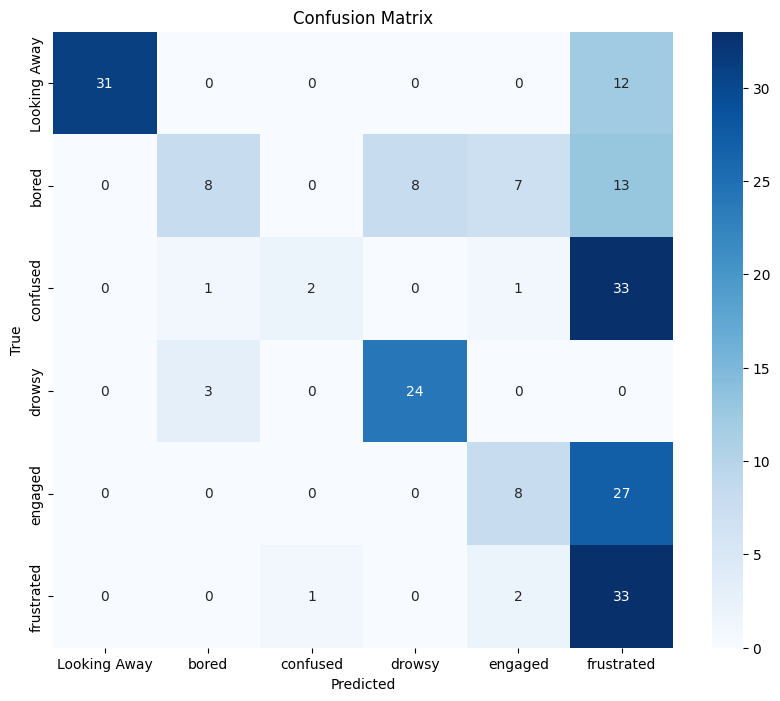

              precision    recall  f1-score   support

Looking Away       1.00      0.72      0.84        43
       bored       0.67      0.22      0.33        36
    confused       0.67      0.05      0.10        37
      drowsy       0.75      0.89      0.81        27
     engaged       0.44      0.23      0.30        35
  frustrated       0.28      0.92      0.43        36

    accuracy                           0.50       214
   macro avg       0.63      0.51      0.47       214
weighted avg       0.64      0.50      0.47       214

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Found 108 misclassified samples.


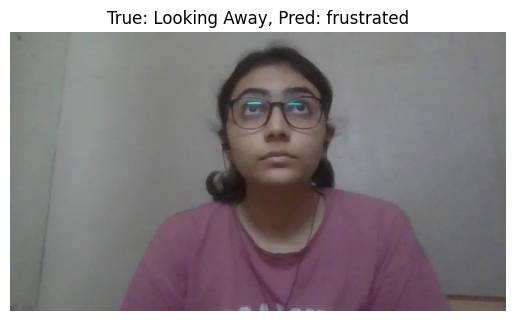

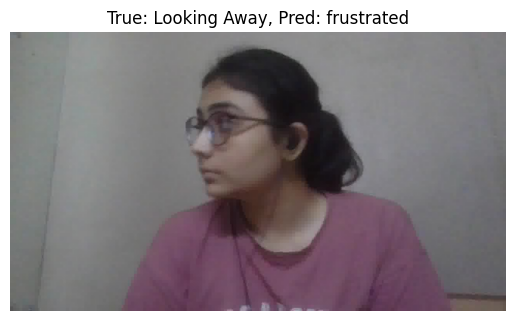

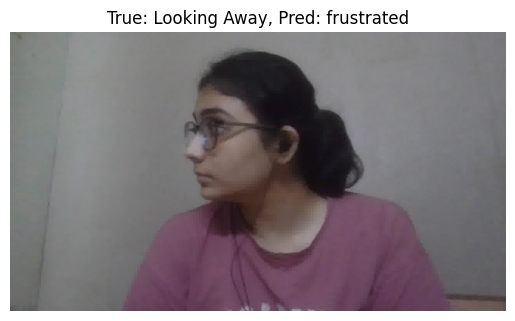

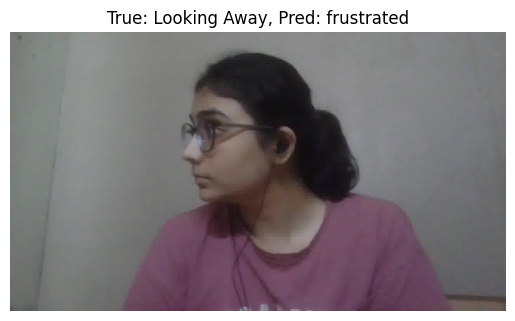

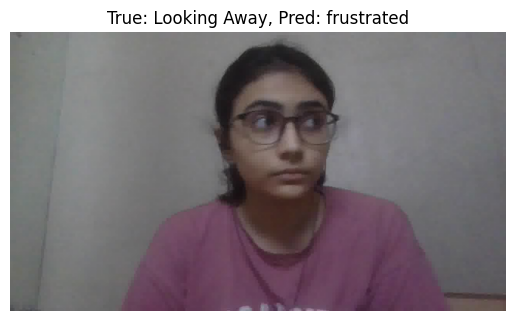

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


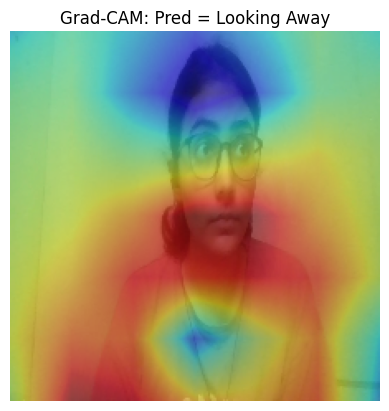

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


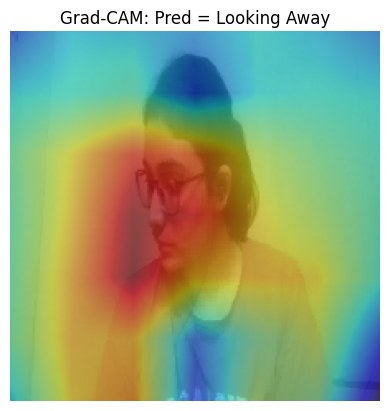

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


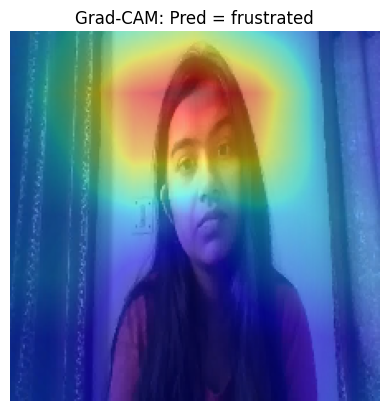

In [ ]:
test_dir = "/content/emotion_dataset_flat/test"
num_classes = 6
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/engagement_emotion"

model = models.load_model(os.path.join(save_dir, "EfficientNetB0_engagement_phase2.keras"), compile=False)

model.trainable = False
for layer in model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 測試與分析
test_generator = get_engagement_testloader(test_dir)
class_names = list(test_generator.class_indices.keys())
evaluate_model(model, test_generator)
plot_confusion_matrix(model, test_generator, class_names, save_dir)
analyze_misclassifications(model, test_generator, class_names)
visualize_gradcam_with_vis(model, test_generator, class_names, layer_name='top_conv', num_samples=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


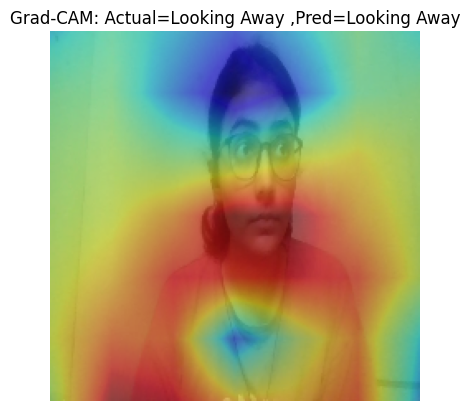

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


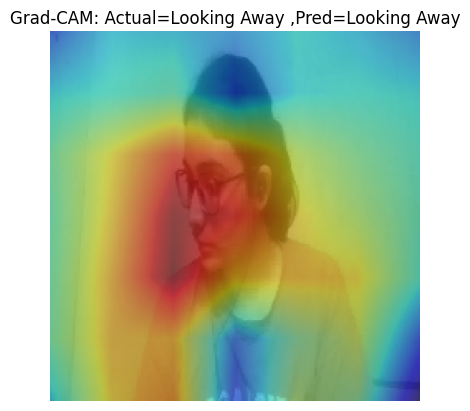

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


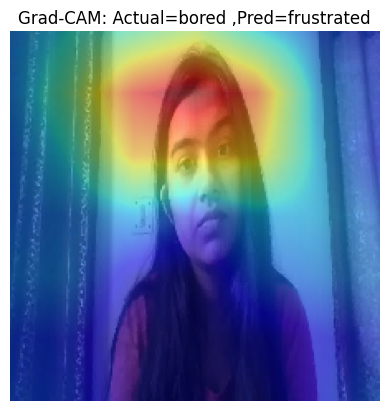

In [ ]:
visualize_gradcam_with_vis(model, test_generator, class_names, layer_name='top_conv', num_samples=3)

# 新增區段

In [ ]:
from tensorflow.keras import models
model = models.load_model("/content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FERplus/EfficientNetB0_FERplus_phase3.keras", compile=False)

for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

  0 | input_layer                              | trainable = True
  1 | rescaling                                | trainable = False
  2 | normalization                            | trainable = False
  3 | rescaling_1                              | trainable = False
  4 | stem_conv_pad                            | trainable = False
  5 | stem_conv                                | trainable = False
  6 | stem_bn                                  | trainable = False
  7 | stem_activation                          | trainable = False
  8 | block1a_dwconv                           | trainable = False
  9 | block1a_bn                               | trainable = False
 10 | block1a_activation                       | trainable = False
 11 | block1a_se_squeeze                       | trainable = False
 12 | block1a_se_reshape                       | trainable = False
 13 | block1a_se_reduce                        | trainable = False
 14 | block1a_se_expand                        | trainable = Fa